In [1]:
# Initialisation model
import sys
import os
import torch
from optimizer import Optimizer
from config import Config
import glob
import tqdm
sys.path.insert(0,'/content/NextFace') # Verify your path

# Load configuration file
config = Config()
config.fillFromDicFile('./optimConfig.ini')
config.device = 'cuda' 
config.path = './baselMorphableModel/' 

# Directory path containing all images

outputDir = './output/debug/'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)  # Create the output directory if it doesn't exist
    
torch.cuda.set_device(0)

c:\Users\dani_\anaconda3\envs\faceNext\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!
loading optim config from:  ./optimConfig.ini


Loading Basel Face Model 2017 from ./baselMorphableModel//morphableModel-2017.pickle...
loading mesh normals...
loading uv parametrization...
loading landmarks association file...
creating sampler...


c:\Users\dani_\anaconda3\envs\faceNext\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading image from path: input/detailled_faces_unsplash/bikerman_256.jpg
detecting landmarks using: fan


c:\Users\dani_\Desktop\repos\NextFace\landmarksfan.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(landmarks, device = self.device)
init camera pose...
1/3 => Optimizing head pose and expressions using landmarks...
100%|██████████| 2000/2000 [00:47<00:00, 42.34it/s]


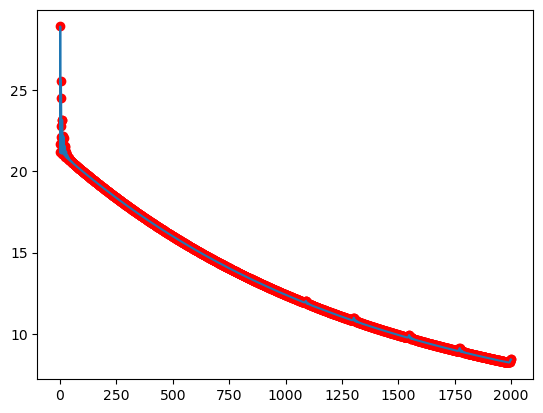

In [2]:
# Create the optimizer and input image
imagePath = "input/detailled_faces_unsplash/bikerman_256.jpg"
optimizer = Optimizer(outputDir, config)

# Choose Redner and set image
optimizer.renderer = "redner"
optimizer.setImage(imagePath, False) # sharedIdentity

# Run the first optimisation
optimizer.runStep1()

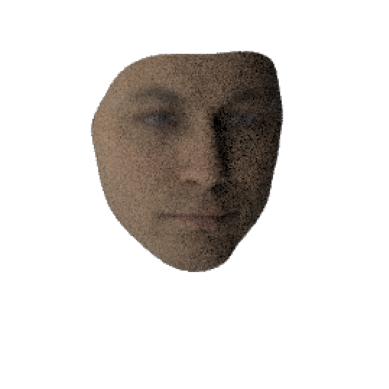

In [3]:
def renderRedner(spp=None):
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    
    # Uses the default albedo, specular and roughness from the morphomable model
    vDiffTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    vSpecTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    vRoughTextures = optimizer.pipeline.vRoughness
    
    # Render the image (possible to change the number of spp)
    if spp != None:
        tmpSpp = optimizer.pipeline.renderer.samples
        optimizer.pipeline.renderer.samples = spp
    out = optimizer.pipeline.render(None, vDiffTextures, vSpecTextures, vRoughTextures)
    if spp != None:
        optimizer.pipeline.renderer.samples = tmpSpp
    
    return out

def show(img):
    import matplotlib.pyplot as plt
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2))
    
img = renderRedner()
show(img.cpu().detach()[0])

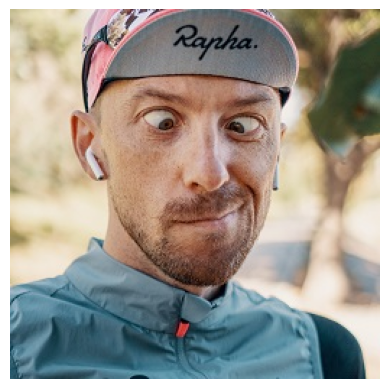

In [4]:
# Now try to compute the variance from the process
inputTensor = torch.pow(optimizer.inputImage.tensor, optimizer.inputImage.gamma)
show(inputTensor.cpu()[0])

100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


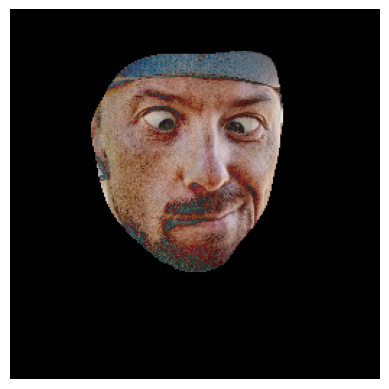

In [5]:
# Learn the lighting and Albedo
parameters_opt = torch.optim.Adam([
    {'params': optimizer.pipeline.vShCoeffs, 'lr': 0.005},
    {'params': optimizer.pipeline.vAlbedoCoeff, 'lr': 0.007}
])

losses = []
for iter in tqdm.tqdm(range(100)):
    parameters_opt.zero_grad() 
    
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)
    
    # Redner
    rgba_img = optimizer.pipeline.render(cameraVerts, diffuseTextures, specularTextures) #redner
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)
    
    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])
    
    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()
    
    # Advance optimizer
    parameters_opt.step()

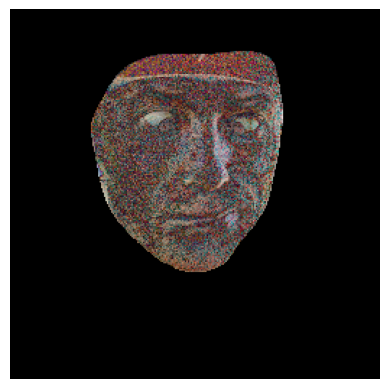

In [6]:
# Last difference
show(diff.cpu().detach()[0])

[48.00223922729492, 46.90485763549805, 45.78053665161133, 44.70291519165039, 43.65788269042969, 42.74482727050781, 41.74552917480469, 40.90625762939453, 39.99491500854492, 39.092952728271484, 38.30414962768555, 37.48418045043945, 36.71562194824219, 35.94620132446289, 35.39170837402344, 34.67850112915039, 34.15528869628906, 33.63564682006836, 33.4178352355957, 33.04094696044922, 32.52566909790039, 32.28483581542969, 32.241004943847656, 32.10654067993164, 31.81541633605957, 31.723384857177734, 31.55586051940918, 31.764694213867188, 31.627033233642578, 31.56214141845703, 31.631010055541992, 31.46520233154297, 31.56945037841797, 31.615650177001953, 31.634674072265625, 31.640689849853516, 31.666973114013672, 31.834199905395508, 31.544523239135742, 31.687686920166016, 31.397226333618164, 31.595279693603516, 31.19994354248047, 31.379148483276367, 31.17627716064453, 31.152786254882812, 31.12451171875, 31.045045852661133, 30.92659568786621, 30.69161033630371, 30.79405975341797, 30.4311275482177

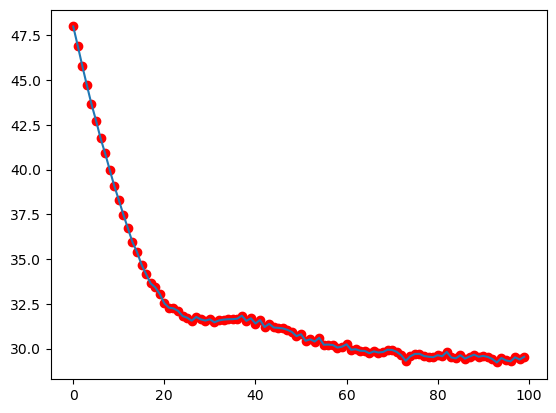

In [7]:
# Show loss 
print(losses)
optimizer.plotLoss(losses, 1, optimizer.outputDir + 'checkpoints/stage2_loss.png')

In [8]:
import matplotlib.pyplot as plt
print("Exp:")
print(optimizer.pipeline.vExpCoeff.cpu().detach())
print("Shape:")
print(optimizer.pipeline.vShapeCoeff.cpu().detach())

Exp:
tensor([[-30.9485,  33.9621,  32.1060, -33.5502,  39.1940, -32.7295,  32.4825,
         -29.7065, -34.5058, -34.2620, -33.1185,  33.5582,  34.2696, -37.0453,
          36.7644, -33.6469, -32.6958,  32.3395,  34.4322,  33.8444, -27.7405,
          34.3505,  15.3083, -25.6668, -37.5989,  19.2857, -34.8344,  14.7126,
          21.0755,  -9.1273, -34.8987, -34.9283, -35.5766,  35.5251,  31.5567,
         -31.9024,  31.7845,  33.5285, -32.8219, -26.8933,  23.0645,  -2.0434,
         -12.2571,  32.6881, -35.0538, -27.8506, -27.5028, -34.4693,  22.8920,
          34.0594, -31.7177,  27.2707,  18.0409, -36.0590,  37.7070,  29.2355,
         -19.2383,  13.0938, -23.9754,  27.6596,  23.6055,  -2.9379,  10.4317,
          25.4131,  31.4165,  30.6684, -33.2665,  32.4580,  -8.1853, -24.5558,
         -33.6390, -16.1200, -27.1306,  24.1159,   9.4712,  22.1699, -29.5321,
         -32.0379,  19.9304, -33.0465,  31.3997,  35.4486,  11.7579,  31.9507,
         -28.4281, -31.0946, -29.8870, -17.6243

In [9]:
# Turn off gradients
optimizer.pipeline.vShCoeffs.requires_grad = False
optimizer.pipeline.vAlbedoCoeff.requires_grad = False

# Turn on gradients for the shape and Exp
optimizer.pipeline.vShapeCoeff.requires_grad = True
optimizer.pipeline.vExpCoeff.requires_grad = True

saved_values = []
K = 1000
for i in tqdm.tqdm(range(K)):
    optimizer.pipeline.vShapeCoeff.grad.zero_()
    optimizer.pipeline.vExpCoeff.grad.zero_()

    # Compute one rendering
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)

    # Redner
    rgba_img = optimizer.pipeline.render(cameraVerts, diffuseTextures, specularTextures) #redner
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)

    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])

    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()

    # Show the gradient values for the shape (only)
    # print(optimizer.pipeline.vShapeCoeff.grad)
    # print(optimizer.pipeline.vExpCoeff.grad)
    saved_values += [(optimizer.pipeline.vShapeCoeff.grad.cpu().detach(), optimizer.pipeline.vExpCoeff.grad.cpu().detach())]

100%|██████████| 1000/1000 [15:08<00:00,  1.10it/s]


In [10]:
ref_grad_shape = saved_values[0][0]
ref_grad_exp = saved_values[0][1]
for (s, e) in saved_values[1:]:
    ref_grad_shape += s
    ref_grad_exp += e
ref_grad_shape /= len(saved_values)
ref_grad_exp /= len(saved_values)
print(ref_grad_shape, ref_grad_exp)

tensor([[-2.1399e-03, -1.0201e-02,  1.9221e-05, -4.9547e-03,  9.4867e-03,
         -5.8088e-03, -1.0006e-02, -2.2550e-03,  3.0170e-03, -1.3243e-04,
         -1.0070e-02, -3.9642e-03,  3.2571e-03,  1.1498e-02, -3.3913e-05,
         -3.3377e-04, -5.5768e-03,  2.1808e-03, -5.4542e-04,  4.1247e-03,
          2.2346e-03,  1.7042e-03, -9.6825e-03,  4.7191e-03,  5.8801e-03,
          3.3541e-03,  4.3109e-04,  5.8595e-03,  4.7107e-03,  2.4660e-03,
         -2.5419e-03, -2.2218e-03, -4.7641e-03, -7.9620e-03,  6.6800e-03,
          4.7372e-03, -9.5479e-04,  6.7482e-04,  4.8381e-03, -1.9418e-04,
         -2.6400e-03,  2.1984e-03, -5.3712e-03,  4.4917e-03, -8.4538e-03,
         -1.0638e-02, -6.6464e-03, -7.3088e-04, -5.2941e-03,  1.1563e-03,
          2.1536e-03, -8.7983e-03,  1.6047e-03,  5.8345e-04,  1.3193e-03,
          4.3982e-03, -8.7561e-03, -3.0492e-04, -1.7680e-03, -2.4004e-03,
         -4.1178e-03,  2.1881e-03, -3.8312e-03, -7.4566e-03, -1.5016e-03,
         -6.7887e-03,  5.9392e-03, -8.

torch.Size([1, 199])


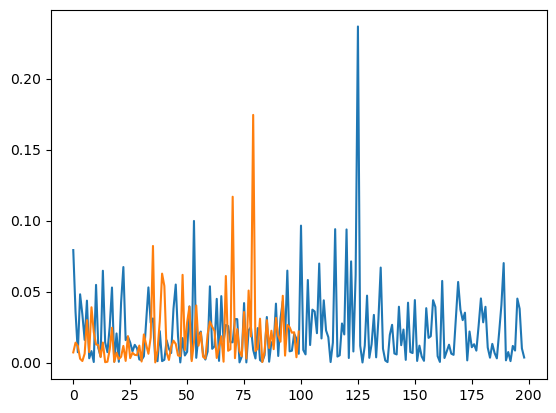

In [11]:
# Compute variance
var_diff_shape = torch.zeros_like(ref_grad_shape)
var_diff_exp = torch.zeros_like(ref_grad_exp)
for s, e in saved_values:
    var_diff_shape += torch.square(s - ref_grad_shape)
    var_diff_exp += torch.square(e - ref_grad_exp)
var_diff_shape /= len(saved_values)
var_diff_exp /= len(saved_values)
print(saved_values[0][0].shape)
plt.plot(range(saved_values[0][0].shape[1]), var_diff_shape[0].numpy())
plt.plot(range(saved_values[0][1].shape[1]), var_diff_exp[0].numpy())
plt.show()

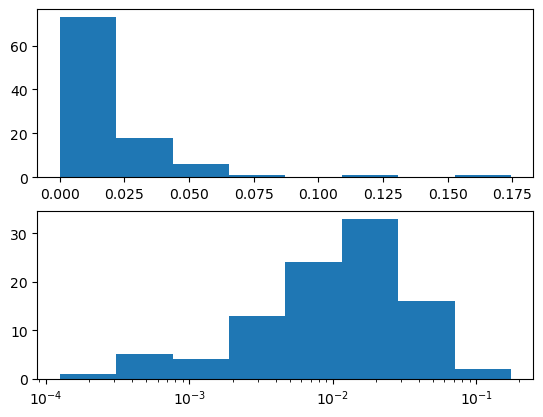

In [12]:
import numpy as np
def show_hist(x):
    # histogram on linear scale
    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=8)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

show_hist(var_diff_exp.numpy()[0])

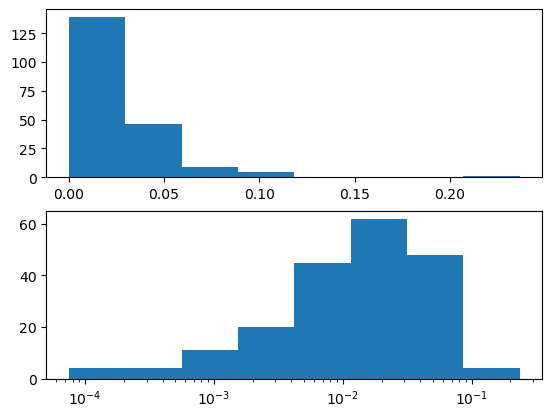

In [13]:
show_hist(var_diff_shape.numpy()[0])